In [96]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from d2l import torch as d2l

In [97]:
class RNNConcise(nn.Module, d2l.HyperParameters):
    def __init__(self, vocab_size, num_inputs, num_hiddens, lr = 0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()
    
    def init_params(self):
        self.rnn = nn.RNN(self.num_inputs, self.num_hiddens)
        self.linear = nn.LazyLinear(self.vocab_size)

    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')
    
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        return l

    def one_hot(self, X):
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)
    
    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])
    

In [98]:
### Model hyperparameters
# num_inputs = vocab_size = num_output
batch_size, num_hiddens, num_steps = 1024, 32, 32

data = d2l.TimeMachine(batch_size, num_steps)
vocab = data.vocab
num_inputs = len(vocab)
model = RNNConcise(len(vocab), num_inputs, num_hiddens, lr = 1)

X = torch.ones(size = (batch_size, num_steps), dtype = torch.int64)
outputs = model(X)
outputs.shape

torch.Size([1024, 32, 28])

In [99]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Model summary
model.to(DEVICE)
# list(model.parameters())

RNNConcise(
  (rnn): RNN(28, 32)
  (linear): Linear(in_features=32, out_features=28, bias=True)
)

In [100]:
model.predict('it has', 20, data.vocab, DEVICE)

'it hasvuuvvvvvvvvvvvvvvvvv'

In [101]:
train_iter = data.get_dataloader(True)
val_iter = data.get_dataloader(False)

def prepare_batch(batch):
    if DEVICE == "cuda":
        batch = [x.to(DEVICE) for x in batch]
    return batch

def train(model : RNNConcise, data, max_epochs = 100):
    optim = torch.optim.SGD(model.parameters(), model.lr)
    animator = d2l.Animator(
        xlabel = "epoch", ylabel = "perplexity", legend = ["train", "valid"]
    )
    for epoch in range(max_epochs):
        model.train()
        train_ppl = []
        valid_ppl = []
        for batch in train_iter:
            loss = model.training_step(prepare_batch(batch))
            optim.zero_grad()
            loss.backward()
            d2l.grad_clipping(model, 1)
            optim.step()
            train_ppl.append(np.exp(loss.cpu().detach().numpy()))
        
        for batch in val_iter:
            with torch.no_grad():
                loss = model.validation_step(prepare_batch(batch))
                valid_ppl.append(np.exp(loss.cpu().detach().numpy()))
        animator.add([epoch + 1] * 2, [np.mean(train_ppl), np.mean(valid_ppl)])

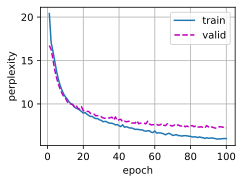

In [102]:
train(model, data)

In [103]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has man a dimension in '